# Reinforcement Learning: DQNs

source: https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c


# Introduction
***

This project is about solving a reinforcement problem with an algorithm so called deep Q-Learning. 

This problem was first solved by the researchers from Google DeepMind. This tutorial is based on the main ideas from their early research papers (especially this and this). 

## Deep Q-Network
DQN is introduced in 2 papers, Playing Atari with Deep Reinforcement Learning on NIPS in 2013 and Human-level control through deep reinforcement learning on Nature in 2015. Interestingly, there were only few papers about DRN between 2013 and 2015. I guess that the reason was people couldn’t reproduce DQN implementation without information in Nature version.

More formally, this project uses artificial neural networks as non-linear function approximator with weights $\theta$ for the action-value function:

$$
\mathcal{N}_{\theta}(i_t) \approx q^*(i_t, a_t) = \mathbb{E} [ r_{t+1} + \gamma \max_{a} q^*(i_{t+1}, a_{t+1} ) ]
$$
where $i$ is a observed state and $a$ the choosen action. 


**Q Learning**
  

In the structure of the agent are two separate models placed. Each is a neural network with the same hyperparameter, but they differ temporarely in the parameter vector. 

$\mathcal{N}_{\theta_1}(i)$, $\mathcal{N}_{\theta_2}(i)$

The first network, the action model, is responsible for the estimation of the action during the experimental phase. It outputs the q values on which the agent actual decide which action to take given a state.
The second model, on the other side, has the task to provide the target q values for training the first network. 
Therefore it is called the target model and uses the replay memory during the learning phase.

The idea behind the replay experience is:

- For the basic Q-learning algorithm we need many thousand states from the game-environment in order to learn important features so the Q-values can be estimated.
- Experience Replay is originally proposed in Reinforcement Learning for Robots Using Neural Networks in 1993. DNN is easily overfitting current episodes. Once DNN is overfitted, it’s hard to produce various experiences. To solve this problem, Experience Replay stores experiences including state transitions, rewards and actions, which are necessary data to perform Q learning, and makes mini-batches to update neural networks. This technique expects the following merits:

    - reduces correlation between experiences in updating DNN
    - increases learning speed with mini-batches
    - reuses past transitions to avoid catastrophic forgetting




The learning or replay is invoked when the memory is full of recording from the experiment. The target model takes then each memory recording and does the q learning update: 


## Game Environment

The playbox from `openAI` for developing and comparing reinforcement learning algorithms is the library called `gym`.
This library inclued several environments or test problems that can be solved with reinforcement algorithm. 
It provides easy shared interfaces, which enables to skip the complex manual feature engineering. 


This project captures the learning problem `MountainCar`. 
Here is the challenge that a car, stocked between two hills, need to climb the right hill, but the a single impulse cause a to less momentum. The only way to solve the problem is that the agent drives front and back to generate a stronger momentum. 
Typically, the agent does not know about this approach and how to solve this efficiently.
A Moore, Efficient Memory-Based Learning for Robot Control, PhD thesis, University of Cambridge, 1990. first discribed the problem.

![](mountainCar.png)

This is the `MountainCar` evironment from gym.

In [2]:
env = gym.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


The spaces for the action is disrcet and there are 3 possible actions availible.
$$
a \in \mathcal{A} = \{0, 1, 2\}
$$


number | action  
-------|-------  
0      | push left
1      | no operation
2      | push right

In [3]:
env.action_space

Discrete(3)

The observation space $\boldsymbol{i}$ is an `2` dimensional vector. The first dimention tells the position of the car and the second the velocity, whereas both values are continious and fall into two intervalls:

$$
\boldsymbol{i} = (i_1, i_2)' \in \mathcal{S} = [-1.2, 0.6] \times [-0.07, 0.07]
$$

number | action  
-------|-------  
$i_1$  | position
$i_2$  | velocity

In [4]:
print(env.observation_space)
print("Lower bound is :: {}".format(env.observation_space.low))
print("Upper bound is :: {}".format(env.observation_space.high))

Box(2,)
Lower bound is :: [-1.2  -0.07]
Upper bound is :: [0.6  0.07]


## Reward 

The reward is set to be -1 for each time step except the goal position of $0.5$ is reached.
$$
r \in \mathcal{R} = \{-1, 0\}
$$

## Terminal State
The terminal state determnines the end of an epsiode and is either when the car is in state $\boldsymbol{i}_{200}$ or in the state $\boldsymbol{i}_t = (0.5, i_{t2})$ with $t \leq 200$.


# Training
***


In [1]:
import deepQLearningSimple as dql
import gym
from keras.models import load_model 
from gym.envs.classic_control.mountain_car import MountainCarEnv
from gym.wrappers.time_limit import TimeLimit

def PatientMountainCar():
    env = MountainCarEnv()
    return TimeLimit(env, max_episode_steps = 10000)

Using TensorFlow backend.


In [174]:
try: 
    env.close()
except:
    pass

#env = gym.make("MountainCar-v0")
env = PatientMountainCar()
agent = dql.agent(env  = env, training = True, render = False)

# Training
agent.run(num_episode = 500, num_steps = 500)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
 Game :: 1 Wins :: 0 Steps :: 500 Reward -500.0 Mean Q Value :: 0.1420154869556427  
	Replay memory is sufficient full, start with inner trainings loop.
 Game :: 2 Wins :: 0 Steps :: 500 Reward -500.0 Mean Q Value :: 0.14941167831420898  
 Game :: 3 Wins :: 0 Steps :: 500 Reward -500.0 Mean Q Value :: -3.7819983959198  


KeyboardInterrupt: 

# Results
***

## Setup

In [7]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("darkgrid")

## Model Parameter 

**Parameter Dimension**  
0. Input zu Layer 1: 2x24   
1. Error: 24
2. Layer 1 zu Layer 2: 24x48  
3. Error: 48  
4. Layer 2 zu Layer 3: 48x24   
5. Error: 24  
6. Layer 3 zu Output: 24x3
7. Error 3

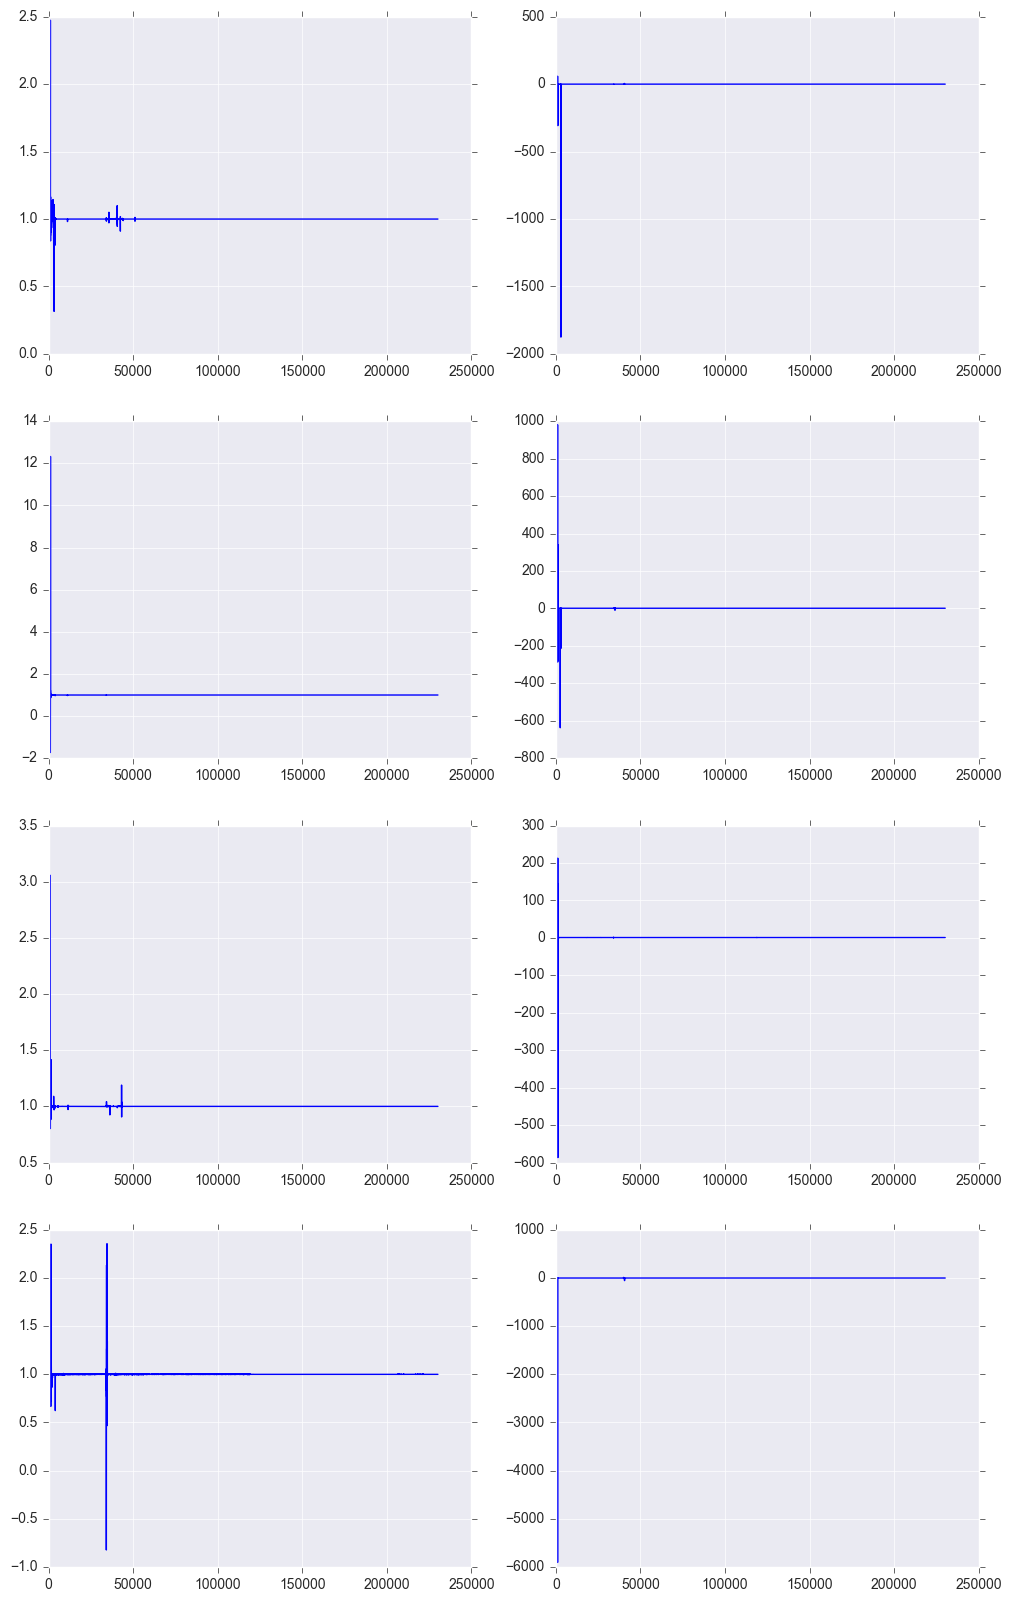

In [162]:
model = agent.action_dqn
idx_layer = range(len(model.get_weights()))
idx_history = range(len(model.weights_history))

def ma(x,y):
    smoothing_factor = 0.00001
    return np.mean( (x + smoothing_factor) / (y + smoothing_factor))
    
#Plot parameter
fig, axes = plt.subplots(4, 2, figsize = (12, 20))
column = 0
row = 0

for layer in idx_layer:
    
    row += 0.5001
    column += 1
    
    if column > 2:
        column = 1
        
    # Filter weights per layer
    weights_history_layer = [model.weights_history[i][layer] for i in idx_history]
    
    # Calculate
    changing_rate_layer = [ma(weights_history_layer[i + 1], weights_history_layer[i]) for i in idx_history if i < len(weights_history_layer) - 1 ]
    
    #Plot
    axes[round(row) - 1][column - 1].plot(changing_rate_layer)

## Wins

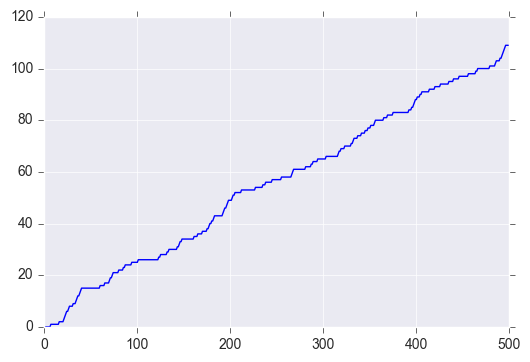

In [166]:
plt.plot(agent.wins_all)

## Reward

(array([391.,   0.,  13.,  12.,  17.,  22.,  19.,  13.,   5.,   8.]),
 array([-500. , -448.7, -397.4, -346.1, -294.8, -243.5, -192.2, -140.9,
         -89.6,  -38.3,   13. ]),
 <a list of 10 Patch objects>)

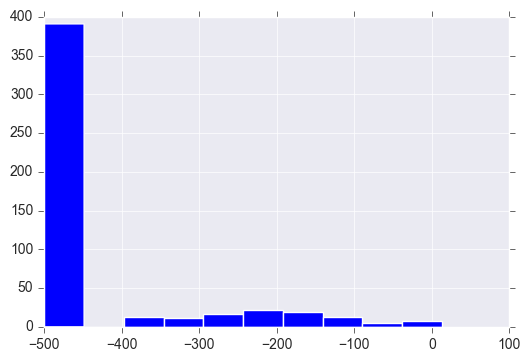

In [172]:
plt.hist(agent.reward_all, bins=10)

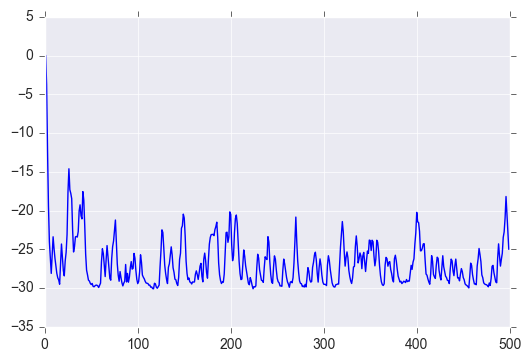

In [173]:
plt.plot(agent.mean_action_value_all)